# HumBug data processing

### Note, this notebook contains two sets of functions for processing data. One is concerned with labels from the Culex labelled dataset. The other, with suffix _cdc, is currently in place to experiment with the algorithm in unlabelled datasets

The functions associated with the CDC dataset require some building blocks from the culex data functions.

A minimal working example (for the hand-labelled Culex set) consists of running all the cells sequentially in Section 1, and is highly recommended for validating operation of every code block.

In [1]:
#import audacity
import numpy as np
import sys 
import os, os.path
from scipy.io.wavfile import read, write
from scipy import signal
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

import random

# Keras-related imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.models import load_model

# Data post-processing and analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import itertools


Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


# Section 1: Culex hand-labelled dataset
Data and label paths relative to maintain compatibility over multiple devices. Adjust as necessary

In [2]:
# Culex data (labelled with data_dz_corrob etc.)
data_path = '../../../../Resources/HumBug/Culex Quinquefasciatus/audio/'
dirs = os.listdir(data_path)

# labels
label_path = '../../../../Resources/HumBug/Culex Quinquefasciatus/labels/'
dirs_label = os.listdir(label_path)


label_list = []
label_names = []

# Process .txt labels. Create list with structure:
# list of [start_time, end_time, tag] entries
signal_list = []

for file in dirs:
    if file.endswith('.wav'):
        fs, signal = read(data_path + file)
        print 'Processing', file
        signal_list.append(signal)
print 'Processed %i files.'%len(signal_list) 
       
for file in dirs_label:
    if file.endswith('.txt'):
        filename = label_path + file
        with open(filename) as f:
            reader = csv.reader(f, delimiter = ' ')
            label_list.append(list(reader)) # Class labels
            label_names.append(file) # Save class name in separate array
print 'Processed %i labels.'%len(label_list) 


Processing 0001_norm.wav
Processing 0002_norm.wav
Processing 0003_norm.wav
Processing 0004_norm.wav
Processing 0005_norm.wav
Processing 0006_norm.wav
Processing 0007_norm.wav
Processing 0008_norm.wav
Processing 0009_norm.wav
Processing 0010_norm.wav
Processing 0011_norm.wav
Processing 0012_norm.wav
Processing 0013_norm.wav
Processing 0014_norm.wav
Processing 0015_norm.wav
Processing 0016_norm.wav
Processing 0017_norm.wav
Processing 0018_norm.wav
Processing 0019_norm.wav
Processing 0020_norm.wav
Processing 0021_norm.wav
Processing 0022_norm.wav
Processing 0023_norm.wav
Processing 0024_norm.wav
Processing 0025_norm.wav
Processing 0026_norm.wav
Processing 0027_norm.wav
Processing 0028_norm.wav
Processing 0029_norm.wav
Processing 0030_norm.wav
Processing 0031_norm.wav
Processing 0032_norm.wav
Processing 0033_norm.wav
Processing 0034_norm.wav
Processing 0035_norm.wav
Processing 0036_norm.wav
Processing 0037_norm.wav
Processing 0038_norm.wav
Processing 0039_norm.wav
Processing 0040_norm.wav


If implementing a sort of majority voting (`maj_vote = True`), specify the `count_method` with a string. Options are:

`'most_positive'`: If any label contains a positive, assign a label of +1

`'two_or_more'`: if two or more labels agree, assign that label

`'agreement'`: only assign samples where each label agrees.

Any other string will result in a ValueError.

In [5]:
#### Options for visualisation are commented out. ###
### Uncomment if desired, to see how the label aligns with the signal and its spectrogram ###

# Select majority voting or other options
maj_vote = False
count_method = 'most_positive'
select_label = 6 # 0: ac, 4 cm, 5 dz, 6 ms


print 'Be aware of index offset with Python lists and file names'

t = np.array(label_list[0])
print label_names


label_interval = 0.1 # Enter length of label interval in seconds
nfft = 512  # Need to be set to the same parameters as used in the spectrogram processing function proc_data_humbug
overlap = 256
spec_fs = (1.*fs/(nfft - overlap))



t_array = []

#ii = 34  # Index for visualisation

#plt.figure(figsize = (10,10))
#plt.title('Signal #%i'%(ii))
#im = plt.specgram(signal_list[ii], Fs = fs, NFFT = nfft, noverlap = overlap)
#plt.show()
#plt.figure(figsize = (10,10))

if maj_vote:
    for who in [0,4,5,6]:
        t = []    

        print 'Using label', label_names[who]
        for index, item in enumerate(label_list[who]):
            t_entry = [float(i) for i in item]
            t.append(t_entry[:len(signal_list[index-1])])    # -1 Corrects for extra label present

        t = np.delete(t, (0), axis = 0)
        t_array.append(np.array(t))
        print 't shape post processing', np.shape(t.squeeze())

        print 't array shape', np.shape(t_array)


#         t_initial = np.arange(0, len(t[ii]))
#         t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
#         t_corrected = np.interp(t_final, t_initial, t[ii])
#         t_corrected = np.rint(t_corrected)

#         plt.plot(t_final/(1./label_interval), t_corrected, '.-')

#     print 'number of specgram time windows', len(im[2])
#     print 'number of time labels', len(t_corrected)
#     print 'last spectrogram time', im[2][-1]
#     print 'Length of t_initial', len(t[ii])
#     print 'Length of t_final', len(t_corrected)

    t = np.zeros([57,600])

    t_array = np.array(t_array)
    for j in range(np.shape(t_array)[1]):
        for i in range(np.shape(t_array)[2]):
            count = Counter(t_array[:,j,i])
            if count_method == 'two_or_more':
                if count[0] == count[1]:  # Tiebreak
                    t[j,i] = 1.  # As a result, 2 or more 1s are classified as 1
                else:
                    t[j,i] = count.most_common()[0][0]
            elif count_method == 'agreement':
                if max([count[0], count[1]]) == 4:
                    t[j,i] = np.argmax([count[0], count[1]])
                else:
                    t[j,i] = 3.
                    #remove the fucking sample marked as 3. jesus fuck that shit
            elif count_method == 'most_positive':
                if count[1] >= 1:  # If any label predicts a 1, classify as 1
                    t[j,i] = 1.  
                else:
                    t[j,i] = 0.
            else:
                raise ValueError('Specified count method does not exist')
              

    t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
    t_corrected = np.interp(t_final, t_initial, t[ii])
    t_corrected = np.rint(t_corrected)
    plt.plot(t_final/(1./label_interval), t_corrected, '.-')
    plt.legend([label_names[0], label_names[4], label_names[5], label_names[6], count_method], loc=2,prop={'size':6})
    plt.xlabel('Sample number')
    plt.ylim([-0.1, 1.1])
    plt.title('Time (s) #%i'%ii)
    plt.show()

# Alternative processing and visualisation

else: 

    t = []    

    print 'Using label', label_names[select_label]
    for index, item in enumerate(label_list[select_label]):
        t_entry = [float(i) for i in item]
    #     t_entry = np.repeat(t_entry,int(label_interval*fs))  # Upsample labels to match sample rate of signal
        t.append(t_entry[:len(signal_list[index-1])])    # -1 Corrects for extra label present

    t = np.delete(t, (0), axis = 0)
    t_array.append(np.array(t))
    print 't shape post processing', np.shape(t.squeeze())

    print 't array shape', np.shape(t_array)


#     t_initial = np.arange(0, len(t[ii]))
#     t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
#     t_corrected = np.interp(t_final, t_initial, t[ii])
#     t_corrected = np.rint(t_corrected)

#     plt.plot(t_final/(1./label_interval), t_corrected, '.-')
#     plt.legend([label_names[select_label]])
#     print 

#     print 'number of specgram time windows', len(im[2])
#     print 'number of time labels', len(t_corrected)
#     print 'last spectrogram time', im[2][-1]
#     print 'Length of t_initial', len(t[ii])
#     print 'Length of t_final', len(t_corrected)



Be aware of index offset with Python lists and file names
['data_corrob_ac.txt', 'data_corrob_all_0or1.txt', 'data_corrob_all_0to1.txt', 'data_corrob_all_1to4.txt', 'data_corrob_cm.txt', 'data_corrob_dz.txt', 'data_corrob_ms.txt']
Using label data_corrob_ms.txt
t shape post processing (57L, 600L)
t array shape (1L, 57L, 600L)


In [6]:
def proc_data_humbug(signal_list, t, fs, img_height, img_width, nfft = 512, overlap = 256, label_interval = 0.1):
               
    """Returns the training data x,y and the parameter input_shape required for initialisation of neural networks. 
    
    Takes as input arguments a signal list, and its associated time coordinates t. Would probably be better to integrate into
    one function, however remains separate as a t input was not required for the birdsong application (the origin of this 
    function). 
    
    img_height and width are used to determine the dimensions of the spectrogram chunk required as input to the NN. nfft and 
    overlap (optional) parameterise the spectrogram.
    
    label_interval: time interval between labels (in seconds)
    """

    spec_list = []
    t_list = []
    spec_fs = (1.*fs/(nfft - overlap))
    location_to_remove = []
    
    for i, t_i in enumerate(t):

        SpecInfo = plt.specgram(signal_list[i], Fs = fs, NFFT = nfft, noverlap = overlap)
        spec_list.append(np.array(SpecInfo))
        
        t_initial = np.arange(0, len(t_i))
        t_final = np.arange(0, len(t_i),1./(label_interval*spec_fs)) # Match fs_labels to fs_spec
        t_corrected = np.interp(t_final, t_initial, t_i)        
        t_corrected = np.rint(t_corrected)
        
        location = np.where(t_corrected == 3)
        #print 'length of t_corrected', len(t_corrected)
        location_to_remove.append(location)
        t_list.append(t_corrected)
   
    # Removal of samples where there is no mutual agreement, labelled by a 3 in pre-processing
    
    for index, item in enumerate(spec_list):
        t_spec = np.delete(spec_list[index][2], location_to_remove[index])
        f_spec = np.delete(spec_list[index][0], location_to_remove[index], axis = 1)
        short_t = np.delete(t[index], location_to_remove[index])
        
        print index, location_to_remove[index], 'Cut', np.shape(f_spec), 'Original', np.shape(spec_list[index][0])
        
        spec_list[index][0] = f_spec
        spec_list[index][2] = t_spec
###################################################################################################################    
    
    # Dimensions for image fed into network
    nb_classes = 2
    x_train = []
    y_train = []


    for i in np.arange(len(spec_list)):
        n_max = np.floor(np.divide(np.shape(spec_list[i][0])[1],img_width)).astype('int')

        print 'Processing signal number', i
        print 'Length of spec', np.shape(spec_list[i][0])[1]
        print 'Number of training inputs for this signal:', n_max    
        for n in np.arange(n_max):
            #print 'n', n, np.shape(spec_training_list[i][0])
            x_train.append(spec_list[i][0][:img_height,img_width*n:img_width*(n+1)])
            # Match sampling rate of labels to sampling rate of spectrogram output

            if not t_list[i][img_width*n:img_width*(n+1)].size:
                print spec_list[i][0][:img_height,img_width*n:img_width*(n+1)]
                print 'start and stop indices for t and spec', img_width*n, img_width*(n+1)
                plt.figure()
                plt.plot(t_list[i])
                plt.show()
                
                #raise ValueError('No location label found for signal number %i'%i) 
                
            y_train.append(t_list[i][img_width*n:img_width*(n+1)])
    
    
    y_train_mean = np.zeros([np.shape(y_train)[0], nb_classes])
    x_train = np.array(x_train).reshape((np.shape(x_train)[0],1,img_height,img_width))
        
    for ii, i in enumerate(y_train):
        if i.size:
            y_train_mean[ii,0] = int(np.round(np.mean(i)))
            y_train_mean[ii,1] = 1 - y_train_mean[ii,0]
        else:
            raise ValueError('Empty label at index %i'%ii)
    print '\nx dimensions', np.shape(x_train)
    print 'y dimensions', np.shape(y_train_mean)
    #print 'Fraction of positive samples', y_positive_frac

    input_shape = (1, img_height, img_width)
    
    return x_train, y_train_mean, input_shape 

0 (array([], dtype=int64),) Cut (257L, 1679L) Original (257L, 1679L)
1 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
2 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
3 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
4 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
5 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
6 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
7 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
8 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
9 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
10 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
11 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
12 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
13 (array([], dtype=int64),) Cut (257L, 1695L) Original (257L, 1695L)
14 (array([], dtype=int64),) C

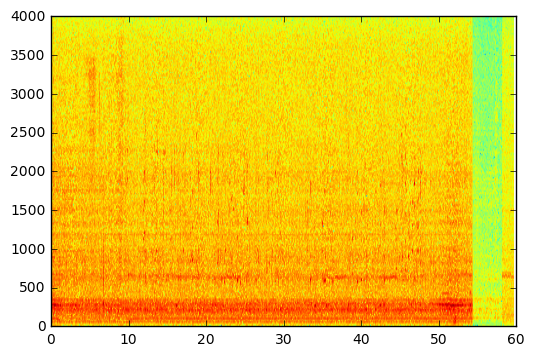

In [8]:
# # Specify whether data to be used in convnet or MLP
conv = True

# Code for withholding signals for test purposes. Mainly for visual comparisons with existing detectors in MozzPy

spec_window = 2

n_fft = nfft
n_overlap = overlap

#test_idx = ii
test_idx = np.array([1,5,19,11,17,18,19,24,28,30,32,35,36,37,38,42,45,49,56,57]) - 1 # Corrected for index convention
train_idx = np.arange(57)
train_idx = np.delete(train_idx, test_idx)

test_x = []
test_t = []
train_x = []
train_t = []

for idx in test_idx:
    test_x.append(signal_list[idx])
    test_t.append(t[idx])

for idx in train_idx:
    train_x.append(signal_list[idx])
    train_t.append(t[idx])

x_test, y_test, input_shape = proc_data_humbug(test_x, test_t, fs, n_fft/2,spec_window, nfft = n_fft, overlap = n_overlap)
x_train_caged, y_train_caged, input_shape = proc_data_humbug(train_x, train_t, fs, n_fft/2,spec_window, nfft = n_fft, overlap = n_overlap)

# Reshape data for MLP
if not conv:
    x_train_caged = x_train_caged.reshape(x_train_caged.shape[0], x_train_caged.shape[-2]*x_train_caged.shape[-1])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[-2]*x_test.shape[-1])

## Neural network execution

### Data prep

Left in this code block to show the syntax for combining training data from different domains. Will correctly concatenate as long as the parameters used in proc_data_humbug and proc_data_humbug_cdc are equivalent.

In [108]:
#x_test = x_test_cdc
#y_test = y_test_cdc

#x_train = np.vstack([x_train_caged, x_train_cdc])  # Augment training data with extra samples from CDC data
#y_train = np.vstack([y_train_caged, y_train_cdc])

### Parameterise network as necessary
For details on parameters, see documentation at:
https://keras.io/getting-started/sequential-model-guide/

and a further example on:
https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [9]:
# CNN parameters

# number of convolutional filters
nb_filters = 16

# size of pooling area for max pooling
pool_size = (2,2)

# convolution kernel size 
kernel_size_1 = (spec_window,spec_window)
kernel_size_2 = (3,3)
# number of classes
nb_classes = 2

# Initialise model

model = Sequential()

# Fully connected first layer to replace conv layer


#model.add(Dense(256, input_dim=(n_fft/2*spec_window)))

model.add(Convolution2D(nb_filters, kernel_size_1[0], kernel_size_1[1],
                       border_mode = 'valid',
                       input_shape = input_shape))
convout1 = Activation('relu')
model.add(convout1)
# # model.add(Convolution2D(nb_filters, kernel_size_2[0], kernel_size_2[1]))

# convout2 = Activation('relu')
# model.add(convout2)
# model.add(MaxPooling2D(pool_size = pool_size))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [10]:
# Train model

batch_size = 64
nb_epoch = 100

filepath = "weights-improvement.hdf5"
#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

# Options to save best performing iteration according to monitor = ?. E.g. 'val_acc' will save the run with the highest 
# validation accuracy.

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
callbacks_list = [checkpoint]
remote = RemoteMonitor(root='http://localhost:9000') # For viewing accuracy measures during training. Experimental.

model.fit(x_train_caged, y_train_caged, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=2)#,callbacks= [remote]) ## validation_data=(X_test_set, Y_test)
#RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})



Epoch 1/100
5s - loss: 4.3413 - acc: 0.6809
Epoch 2/100
5s - loss: 2.9903 - acc: 0.7692
Epoch 3/100
5s - loss: 2.9989 - acc: 0.7681
Epoch 4/100
5s - loss: 2.8054 - acc: 0.7865
Epoch 5/100
5s - loss: 2.8637 - acc: 0.7880
Epoch 6/100
5s - loss: 2.8048 - acc: 0.7938
Epoch 7/100
5s - loss: 2.5772 - acc: 0.8087
Epoch 8/100
5s - loss: 2.5650 - acc: 0.8103
Epoch 9/100
5s - loss: 2.5237 - acc: 0.8129
Epoch 10/100
5s - loss: 2.4935 - acc: 0.8149
Epoch 11/100
5s - loss: 2.3938 - acc: 0.8202
Epoch 12/100
5s - loss: 2.4318 - acc: 0.8182
Epoch 13/100
5s - loss: 2.4025 - acc: 0.8206
Epoch 14/100
5s - loss: 2.2680 - acc: 0.8289
Epoch 15/100
5s - loss: 2.1215 - acc: 0.8346
Epoch 16/100
6s - loss: 2.0409 - acc: 0.8340
Epoch 17/100
6s - loss: 2.0055 - acc: 0.8331
Epoch 18/100
5s - loss: 1.9557 - acc: 0.8339
Epoch 19/100
5s - loss: 1.9575 - acc: 0.8267
Epoch 20/100
5s - loss: 1.9555 - acc: 0.8290
Epoch 21/100
5s - loss: 1.8551 - acc: 0.8310
Epoch 22/100
5s - loss: 1.7121 - acc: 0.8225
Epoch 23/100
5s - l

In [11]:
# Set name for file saving

base_name = 'humbug'
if conv:
    suffix = 'conv'
else:
    suffix = 'MLP'

model_name = (base_name + '_' + suffix + '_' + str(n_fft) + '_' + str(n_overlap) + '_' 
              + str(kernel_size_1[0]) + '_' + str(kernel_size_1[0]) + '_' + count_method)
print 'model_name:', model_name

model_name: humbug_conv_512_256_2_2_most_positive


Code to generate predictions. Note that in a practical implementation on a phone, we will only need to (pre)load a model once, and predict over a test dataset x_test. The test dataset is constructed from sectioning a spectrogram according to proc_data_humbug.

In [12]:
score = model.evaluate(x_test, y_test, verbose=1)
predictions = model.predict(x_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

16352/16412 [============================>.] - ETA: 0s('Test score:', 1.2679346535380729)
('Test accuracy:', 0.82415305869392785)


### Functions necessary for predictions end here. The remaining functions and scripts in Section 1 are for performance analysis and visualisation

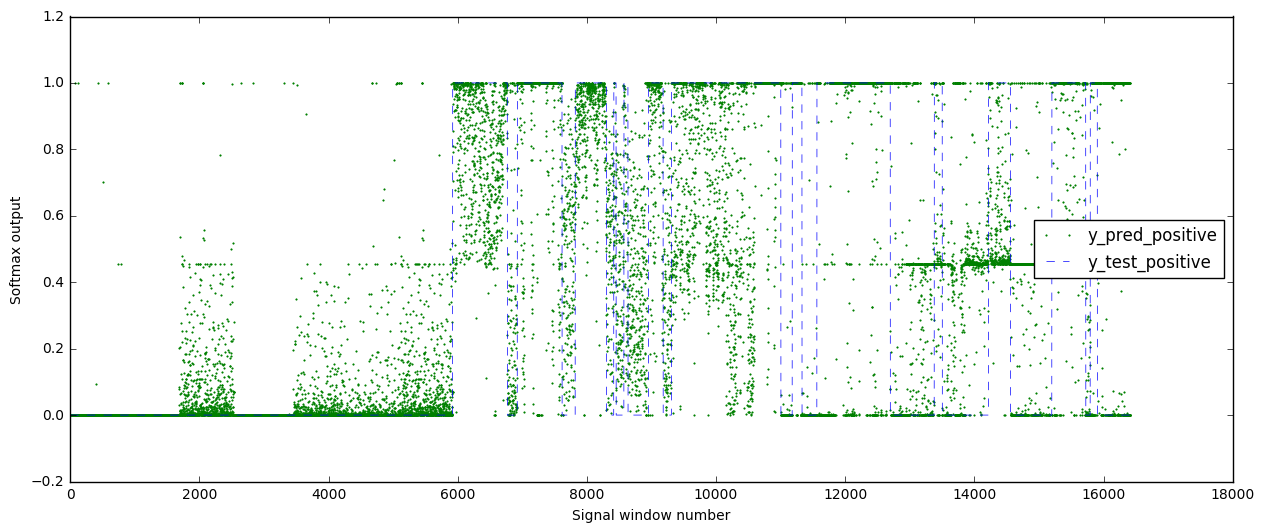

True positive rate 0.734525660964 True negative rate 0.881887397315


In [13]:
########### 2 class predictions #####################################################
positive_predictions = predictions[:,0][np.where(y_test[:,0])]
negative_predictions = predictions[:,1][np.where(y_test[:,1])]

true_positive_rate = (sum(np.round(positive_predictions)))/sum(y_test[:,0])
true_negative_rate = sum(np.round(negative_predictions))/sum(y_test[:,1])

plt.figure(figsize = (15,6))
plt.plot(predictions[:,0],'g.', markersize = 2, label = 'y_pred_positive')
plt.plot(y_test[:,0], '--b', linewidth = 0.5, markersize = 2, label = 'y_test_positive')
    
plt.legend(loc = 7)
plt.ylim([-0.2,1.2])
plt.ylabel('Softmax output')
plt.xlabel('Signal window number')
#plt.savefig('Outputs/' + 'ClassOutput_' + model_name + '.pdf', transparent = True)
#print 'saved as', 'ClassOutput_' + model_name + '.pdf' 
plt.show()
print 'True positive rate', true_positive_rate, 'True negative rate', true_negative_rate



In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[ 0.73452566  0.26547434]
 [ 0.1181126   0.8818874 ]]


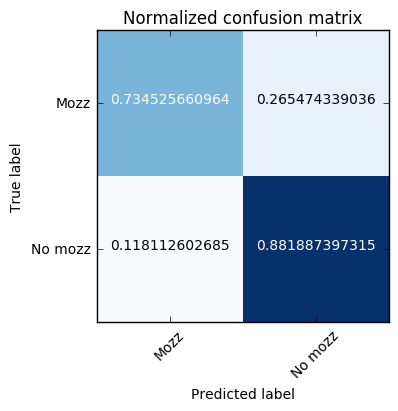

In [15]:
cnf_matrix = confusion_matrix(y_test[:,1], np.round(predictions[:,1]).astype(int))
class_names = ('Mozz','No mozz')
# Plot normalized confusion matrix
plt.figure(figsize = (4,4))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('Outputs/' + 'Conf_' + model_name + '.pdf', transparent = True)
#print 'saved as', 'Conf_' + model_name + '.pdf' 
plt.show()


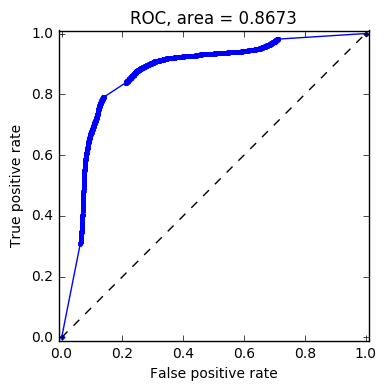

In [16]:
y_true = y_test[:,0]
y_score = predictions[:,0]
roc_score = roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, '.-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC, area = %.4f'%roc_score)
#plt.savefig('Outputs/' + 'ROC_' + model_name + '.pdf')
#print 'saved as', 'ROC_' + model_name + '.pdf' 
plt.show()

# Section 2: CDC dataset functions and scripts

In [17]:
# Caged mosquito (CDC dataset, mostly positive samples, with extreme cases labelled)

data_path = '../../../../Resources/HumBug/labelled recordings/'
dirs = os.listdir(data_path)

label_list = []
label_names = []
signal_list = []

# Process .txt labels. Create list with structure:
# list of [start_time, end_time, tag] entries

for file in dirs:
    if file.endswith('.txt'):
        filename = data_path + file
        with open(filename) as f:
            reader = csv.reader(f, delimiter="\t")
            label_list.append(list(reader)) # Class labels
            label_names.append(file) # Save class name in separate array

signal_path = '../../../../Resources/HumBug/labelled recordings/wav/'             
dirs = os.listdir(signal_path)

for file in dirs:
    if file.endswith('.wav'):
        fs, signal = read(signal_path + file)
        print 'Processing', file
        signal_list.append(signal)
print 'Processed %i files.'%len(signal_list) 

Processing CDC_Ae-aegypti_labelled.wav
Processing CDC_Ae-albopictus_labelled.wav
Processing CDC_An-albimanus_labelled.wav
Processing CDC_An-arabiensis_labelled.wav
Processing CDC_An-atroparvus_labelled.wav
Processing CDC_An-coluzzii_labelled.wav
Processing CDC_An-dirus_labelled.wav
Processing CDC_An-farauti_labelled.wav
Processing CDC_An-freeborni_labelled.wav
Processing CDC_An-funestus_labelled.wav
Processing CDC_An-gambiae-coluzzii-hybrid_labelled.wav
Processing CDC_An-gambiae_labelled.wav
Processing CDC_An-merus_labelled.wav
Processing CDC_An-minimus_labelled.wav
Processing CDC_An-quadriannulatus_labelled.wav
Processing CDC_An-quadrimaculatus_labelled.wav
Processing CDC_An-sinensis_labelled.wav
Processing CDC_An-stephensi_labelled.wav
Processing CDC_Cx-quinquefasciatus_labelled.wav
Processing CDC_Cx-tarsalis_labelled.wav
Processed 20 files.


In [18]:
# Script to extract and format cdc labels for compatibility with proc_data_humbug_cdc

running_time = []
positive_signal_list = []

n = 0
for i in range(len(label_list)):
    positive_signal = []
    for j in range(len(label_list[i])):

        start_time = label_list[i][j][0]  # Convert starting time in seconds to sample
        end_time = label_list[i][j][1]
        start_sample = int(np.floor(np.float32(start_time) * fs))
        end_sample = int(np.ceil(np.float32(end_time) * fs))
        positive_signal.append(signal_list[i][start_sample:end_sample])
        n += len(positive_signal[j])
        duration = (np.float(label_list[i][j][1]) - np.float(label_list[i][j][0]))
        running_time.append(duration)
    positive_signal_list.append(positive_signal)
    
print 'number of samples labelled', n
print 'Total running time (s)', np.sum(running_time)



number of samples labelled 1061669
Total running time (s) 132.642724


In [20]:
def proc_data_humbug_cdc(positive_signal_list, fs, img_height, img_width, nfft = 512, overlap = 256):

    nb_classes = 2
    spec_list_positive = []
    x_train = []
    y_train_count = []
    
    for i, positive_signal in enumerate(positive_signal_list):
        for chunk in positive_signal:
            SpecInfo = plt.specgram(chunk, Fs = fs, NFFT = nfft, noverlap = overlap)
            spec_list_positive.append(SpecInfo)

    for i in np.arange(len(spec_list_positive)):
        n_max = np.floor(np.divide(np.shape(spec_list_positive[i][0])[1],img_width)).astype('int')

        print 'Processing signal number', i
        print 'Length of spec', np.shape(spec_list_positive[i][0])[1]
        print 'Number of training inputs for this signal:', n_max    
        for n in np.arange(n_max):
            #print 'n', n, np.shape(spec_training_list[i][0])
            x_train.append(spec_list_positive[i][0][:img_height,img_width*n:img_width*(n+1)])


            y_train_count.append(1)

    y_train = np.zeros([np.shape(y_train_count)[0], nb_classes])
    y_train[:,0] = (np.array(y_train_count).astype(int))
    y_train[:,1] = 1 - (np.array(y_train_count).astype(int))
    x_train = np.array(x_train).reshape((np.shape(x_train)[0],1,img_height,img_width))
    
    return x_train, y_train

In [21]:
def proc_data_humbug_cdc_test(signal_list, fs, img_height, img_width, nfft = 512, overlap = 256):
    x_train = []

    SpecInfo = plt.specgram(signal_list, Fs = fs, NFFT = nfft, noverlap = overlap)
    n_max = np.floor(np.divide(np.shape(SpecInfo[0])[1],img_width)).astype('int')
    print n_max
    for n in np.arange(n_max):
        x_train.append(SpecInfo[0][:img_height,img_width*n:img_width*(n+1)])

    x_train = np.array(x_train).reshape((np.shape(x_train)[0],1,img_height,img_width))
    y_train = np.zeros([np.shape(x_train)[0], 2])
    y_train[:,0] = 1
    
    return x_train, y_train

Processing signal number 0
Length of spec 13
Number of training inputs for this signal: 1
Processing signal number 1
Length of spec 2
Number of training inputs for this signal: 0
Processing signal number 2
Length of spec 3
Number of training inputs for this signal: 0
Processing signal number 3
Length of spec 12
Number of training inputs for this signal: 1
Processing signal number 4
Length of spec 4
Number of training inputs for this signal: 0
Processing signal number 5
Length of spec 4
Number of training inputs for this signal: 0
Processing signal number 6
Length of spec 3
Number of training inputs for this signal: 0
Processing signal number 7
Length of spec 2
Number of training inputs for this signal: 0
Processing signal number 8
Length of spec 2
Number of training inputs for this signal: 0
Processing signal number 9
Length of spec 2
Number of training inputs for this signal: 0
Processing signal number 10
Length of spec 1
Number of training inputs for this signal: 0
Processing signal 

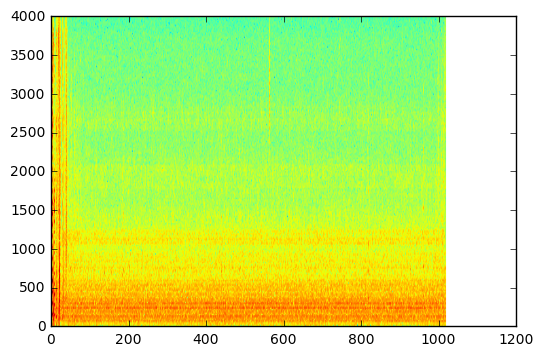

In [22]:
n_fft = 512
n_overlap = 256
spec_window = 10

index = 4  # Choose which cdc signal to use for testing

x_train_cdc, y_train_cdc = proc_data_humbug_cdc(positive_signal_list, fs, n_fft/2,spec_window, nfft = n_fft, overlap = n_overlap)
x_test_cdc, y_test_cdc = proc_data_humbug_cdc_test(signal_list[index], fs, n_fft/2,spec_window, nfft = n_fft, overlap = n_overlap)

### Re-initialise neural network architecture and train as before

## Visualise output from Humbug CDC dataset

In [ ]:
spec_fs = (1.*fs/(n_fft - n_overlap))

score = model.evaluate(x_test_cdc, y_test_cdc, verbose=1)
predictions = model.predict(x_test_cdc)

plt.figure(figsize = (15,15))
plt.subplot(3,1,1)

plt.specgram(signal_list[index], NFFT = n_fft, noverlap = n_overlap, Fs = fs)
#plt.title(label_list[0])

plt.subplot(3,1,2)

positive_predictions = predictions[:,0][np.where(y_test[:,0])]
negative_predictions = predictions[:,1][np.where(y_test[:,1])]

true_positive_rate = (sum(np.round(positive_predictions)))/sum(y_test[:,0])
true_negative_rate = sum(np.round(negative_predictions))/sum(y_test[:,1])

plt.plot(np.arange(len(predictions[:,0]))/(spec_fs)*spec_window, 
         predictions[:,0],'g.', markersize = 2, label = 'y_pred_positive')
plt.plot(np.arange(len(y_test[:,0]))/(spec_fs)*spec_window, 
         y_test[:,0], '--b', linewidth = 0.5, markersize = 2, label = 'y_test_positive')
#plt.title('Window size %i'%spec_window)    
plt.legend(loc = 7)
plt.ylim([-0.2,1.2])
plt.ylabel('Softmax output')
plt.xlabel('Time (s)')

plt.subplot(3,1,3)

plt.plot(np.arange(len(signal_list[index]))/(1.*fs),signal_list[index])
for j in range(len(label_list[index])):
    start_time = label_list[index][j][0]  # Convert starting time in seconds to sample
    end_time = label_list[index][j][1]
    start_sample = int(np.floor(np.float32(start_time) * fs))
    end_sample = int(np.ceil(np.float32(end_time) * fs))
    plt.axvspan(start_sample/(1.*fs), end_sample/(1.*fs), facecolor='#2ca02c', alpha=0.5)
plt.xlabel('Time (s)')
plt.show()

## Utility functions for saving and loading models and data

In [5]:
# (Optional) Load test data for visualisation

loaded_data = np.load('humbug_test.npz')
x_test = loaded_data['x_test']
y_test = loaded_data['y_test']

In [ ]:
# Load model to train further if desired
model_name = 'humbug_3.h5'

# Note, the file closing below is usually not required, and may produce an error when not. Necessary code is tied to a bug
# in keras. For more info see here:
# https://github.com/fchollet/keras/issues/4044

import h5py
f = h5py.File(model_name, 'r+')
del f['optimizer_weights']
f.close()


In [ ]:
model = load_model(model_name)

In [57]:
model.save(model_name + '.h5')
print 'Model saved as', model_name + '.h5'

Model saved as humbug_conv_2048_1024_20_20_most_positive.h5


In [58]:
# Save data

# np.savez('Outputs/' + model_name + '.npz', x_train = x_train_cdc, x_test = x_test, y_train=y_train_cdc, 
#          y_test = y_test, input_shape = input_shape)
np.savez('Outputs/' + model_name + '.npz', x_test = x_test, y_test = y_test)

# Unused code, for illustration/presentation purposes only

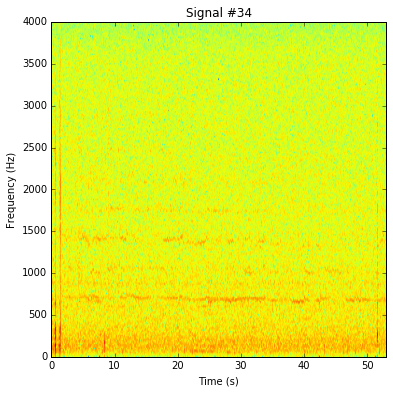

In [18]:
plt.figure(figsize = (6,6))
plt.title('Signal #%i'%(34))
im = plt.specgram(signal_list[34], Fs = fs, NFFT = nfft, noverlap = overlap)
plt.xlim([0,53])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.savefig('SpectrogramPresentation.pdf', transparent = True)
plt.show()



In [75]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 16, 511, 1)    80          convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 16, 511, 1)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 8176)          0           activation_7[0][0]               
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 128)           1046656     flatten_3[0][0]                  
___________________________________________________________________________________________

In [80]:
# Produce diagram of model (not very useful)

from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

In [25]:
n_test = int(0.1*len(x_train)) # Split into test sample percentage

shuffle_index = np.random.permutation(np.shape(y_train)[0])
y_train = y_train[shuffle_index]
x_train = x_train[shuffle_index]


x_test = x_train[:n_test,:,:,:]
y_test = y_train[:n_test,:]
x_train = x_train[n_test:,:,:]
y_train = y_train[n_test:,:]